# __Catapult Range Prediction Model__

## __Library Imports__

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

First, we will import data from raw_data.csv to catapult.db

__Requires__: 
- raw_data.csv file has 3 columns named exactly __Angle_deg__ and __Range_m__ which corresponds to the angle of the arm relative to the ground, and range of projectile, respectively

## __Importing Data__
We will import data from raw_data.csv to a table named Shots in catapult.db

In [2]:
con = sqlite3.connect("catapult.db")
cursor = con.cursor()
df = pd.read_csv("raw_data.csv", dtype = str)
df.to_sql("Shots", con, if_exists="replace", index = False)

print("Database created successfully!")

Database created successfully!


## __Data Cleaning__
Now that we've imported the data, we need to clean it.

We will define functions and use SQL queries to remove rows from
the dataset which contains invalid data.

### __Clean Mass__
We define a function that deletes all rows of the mass we don't want to avoid inconsistency.

In [3]:
def filter_mass(mass):
    # Rows deleted
    cursor.execute("""
    SELECT *
    FROM Shots
    WHERE TRIM(Mass_kg) = ''
       OR Mass_kg IS NULL
       OR CAST(Mass_kg AS REAL) != ?
    """, (mass,))

    print("Rows deleted: ")
    for row in cursor.fetchall():
        print(row)

    # Delete rows
    cursor.execute("""
    DELETE FROM Shots
    WHERE TRIM(Mass_kg) = ''
       OR Mass_kg IS NULL
       OR CAST(Mass_kg AS REAL) != ?
    """, (mass,))

    print("Invalid mass removal complete!\n")

### __Clean Angle__
We define a function that deletes all rows of invalid angle.

i.e. Angle < 0 or Angle > 90 or Null

In [4]:
def filter_angle():
    # Print rows deleted
    cursor.execute("""
    SELECT *
    FROM Shots
    WHERE Angle_deg IS NULL
       OR TRIM(Angle_deg) = ''
       OR CAST(Angle_deg AS REAL) < 0
       OR CAST(Angle_deg AS REAL) > 90
    """)

    print("Rows deleted: ")
    for row in cursor.fetchall():
        print(row)

    # Delete rows
    cursor.execute("""
    DELETE FROM Shots
    WHERE Angle_deg IS NULL
       OR TRIM(Angle_deg) = ''
       OR CAST(Angle_deg AS REAL) < 0
       OR CAST(Angle_deg AS REAL) > 90
    """)

    print("Invalid angle removal complete!\n")

### __Clean Range__
We define a function that deletes all rows of invalid range.

i.e. Range < 0 or Range > 50 or Null

In [5]:
def filter_range():
    # Print rows deleted
    cursor.execute("""
    SELECT *
    FROM Shots
    WHERE TRIM(Range_m) = ''
       OR Range_m IS NULL
       OR CAST(Range_m AS REAL) < 0
       OR CAST(Range_m AS REAL) > 50
    """)

    print("Rows deleted: ")
    for row in cursor.fetchall():
        print(row)

    # Delete rows
    cursor.execute("""
    DELETE FROM Shots
    WHERE TRIM(Range_m) = ''
       OR Range_m IS NULL
       OR CAST(Range_m AS REAL) < 0
       OR CAST(Range_m AS REAL) > 50
    """)

    print("Invalid range removal complete!\n")

### __Remove Duplicates__
We define a function that deletes all rows that has duplicates, leaving a dataset where all rows are unique.

In [6]:
def remove_dup():
    # Print duplicated data
    cursor.execute("""
    SELECT Angle_deg, Range_m, COUNT(*) AS Count
    FROM Shots
    GROUP BY Mass_kg, Angle_deg, Range_m
    HAVING Count > 1
    """)

    print("Duplicated data removed: ")
    for row in cursor.fetchall():
        print(row)

    # Remove duplicates
    cursor.execute("""
    DELETE FROM Shots
    WHERE rowid NOT IN (
        SELECT MAX(rowid)
        FROM Shots
        GROUP BY Mass_kg, Angle_deg, Range_m
        )
    """)
    print("Duplicate removal complete!\n")

### __Data Cleaning Pipeline__
Now we put together the previous functions we defined to create a data cleaning pipeline.

In [7]:
def clean(mass):
    filter_mass(mass)
    filter_angle()
    filter_range()
    remove_dup()
    print("Cleaning complete!")

Now we can call the function to clean the data with a desired mass of 0.057kg. It will display the rows delete.

In [8]:
target_mass = 0.057
clean(target_mass)

con.commit()
cursor.close()
con.close()
print("Committed + closed after cleaning.")

Rows deleted: 
(None, '85.4', '13.26')
('0.05', '27.1', '23.56')
('0.055', '62.9', '27.51')
('0.055', '54.0', '9.19')
(None, '13.3', '25.89')
('0.055', '43.3', '3.72')
(None, '27.3', '29.32')
('0.058', '89.8', '1.41')
('0.058', '58.8', '27.55')
('0.05', '53.8', '4.58')
(None, '17.9', '24.6')
('0.05', '3.8', '27.99')
('0.06', '14.5', '6.84')
(None, '53.3', '29.81')
('0.055', '73.2', '18.44')
('0.055', '40.0', '23.92')
('0.06', '41.5', '11.52')
('0.05', '71.1', '7.5')
('0.05', '35.4', '24.77')
('0.06', '15.4', '18.68')
('0.055', '41.3', '24.13')
('0.06', '10.0', '18.5')
('0.058', '36.2', '1.56')
('0.05', '70.5', '14.77')
('0.05', '28.5', '17.37')
(None, '72.9', '9.09')
('0.056', '62.3', '5.15')
(None, '15.6', '27.81')
('0.05', '41.2', '1.67')
('0.058', '63.8', '21.32')
('0.058', '64.0', '3.73')
('0.05', '89.2', '4.13')
('0.058', '44.3', '3.63')
('0.05', '79.0', '4.93')
(None, '37.5', '18.15')
('0.05', '78.4', '6.74')
('0.05', '32.1', '12.3')
('0.058', '16.1', '5.77')
Invalid mass removal

## __The Prediction Model__
We will first do a train/test split, followed by outlier removal from the training dataset, 
and finally train a polynomial regression model to predict data and validate the model using the test dataset.

### __Train/Test Split__
We split the data into two: training data (80%) and testing data (20%).

In [9]:
con = sqlite3.connect("catapult.db")
df = pd.read_sql_query("SELECT Angle_deg, Range_m FROM Shots", con)

df = pd.read_sql_query("""
        SELECT Angle_deg, Range_m
        FROM Shots             
        """, con)

df["Angle_deg"] = pd.to_numeric(df["Angle_deg"])
df["Range_m"] = pd.to_numeric(df["Range_m"])

train_df, test_df = train_test_split(
    df,
    test_size = 0.2,
    random_state = 21
)

print("Counts")
print("Total: ", len(df))
print("Train: ", len(train_df))
print("Test: ", len(test_df))

train_df.to_sql("Shots_train", con, if_exists = "replace", index = False)
test_df.to_sql("Shots_test", con, if_exists = "replace", index = False)
print()

Counts
Total:  546
Train:  436
Test:  110



### __Outliers Removal__
We remove outliers using bin-based IQR method, where range values are compared within angle value bins of width 3.

Note that a bin is required to have at least 5 samples to prevent IQR from removing good data.

In [10]:
bin_width = 3
train_df["Angle_bin"] = (train_df["Angle_deg"] / bin_width).round().astype(int) * bin_width
groups = train_df.groupby("Angle_bin")["Range_m"]

quant_1 = groups.quantile(0.25)
quant_3 = groups.quantile(0.75)
inter_quant_range = quant_3 - quant_1
lo_bound = quant_1 - 1.5 * inter_quant_range
hi_bound = quant_3 + 1.5 * inter_quant_range

train_df["lo_bound"] = train_df["Angle_bin"].map(lo_bound)
train_df["hi_bound"] = train_df["Angle_bin"].map(hi_bound)

min_sample = 5
sample_count = groups.size()
train_df["Sample_count"] = train_df["Angle_bin"].map(sample_count)

# Identify outliers (False = 0, True = 1)
# Checks for minimum number of samples and returns true if range is not between lo and high, inclusive
train_df["is_Outlier"] = (train_df["Sample_count"] >= min_sample) & (
    ~train_df["Range_m"].between(train_df["lo_bound"], train_df["hi_bound"], inclusive = 'both')
)

train_clean = train_df.loc[~train_df["is_Outlier"], ["Angle_deg", "Range_m"]].copy()
train_clean.to_sql("Shots_train", con, if_exists = "replace", index = False)

print("Outliers removed successfully!")

Outliers removed successfully!


### __Linear/Polynomial Regression__
We can now finally train our model.

In [11]:
X_train = train_clean['Angle_deg'].to_numpy()
y_train = train_clean['Range_m'].to_numpy()

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X_train.reshape(-1, 1))

model = LinearRegression()
model.fit(poly_features, y_train)

y_pred = model.predict(poly_features)

### __Visualization__
Here we can visualize our testing data and the model.

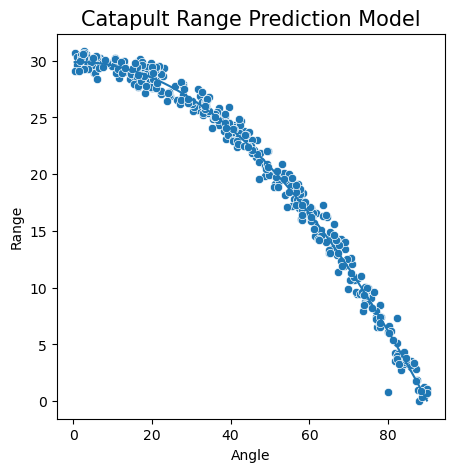

In [12]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_train, y=y_train)
sns.lineplot(x=X_train, y=y_pred)
plt.xlabel("Angle", size=10)
plt.ylabel("Range", size=10)
plt.title("Catapult Range Prediction Model", size=15)

plt.show()

### _Model Validation__
We now validate out using our test dataset and the following metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- R^2 Score

In [13]:
X_test = test_df['Angle_deg'].to_numpy()
y_test = test_df['Range_m'].to_numpy()

test_features = poly.transform(X_test.reshape(-1, 1))
y_pred_test = model.predict(test_features)

# Get metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"\nMAE: {mae:.3f} m")
print(f"RMSE: {rmse:.3f} m")
print(f"R^2: {r2:.3f}")

con.commit()
con.close()


MAE: 0.935 m
RMSE: 1.898 m
R^2: 0.961


As shown above, the model achieved __MAE = 0.935 m__, __RMSE = 1.898 m__, and __R² = 0.961__, meaning predictions are typically within about 1 m and most errors are within about 2 m. Overall, the model fits the experimental trend well and is accurate enough for practical range prediction within the tested angle range.